# Construct a custom Environment for Pair Trading

Some examples on the market
* [custom env example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb#scrollTo=RqxatIwPOXe_)
* [StockTradingEnv by Adam King](https://github.com/notadamking/Stock-Trading-Environment)
* [FinRL](https://github.com/AI4Finance-Foundation/FinRL)

Target is to construct a custom Env for pair trading
This env restrict the behaviour of RL learner to pair trading only

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import csv
import numpy as np
import pandas as pd
import gymnasium as gym
import statsmodels.api as sm

from gymnasium import spaces
from datetime import date
from sklearn.model_selection import train_test_split
from stable_baselines3.common.vec_env import DummyVecEnv
from utils.read2df import read2df

os.makedirs("result/rl-restrict", exist_ok=True)

for root, dirs, files in os.walk(f"result/rl-restrict/"):
    for file in files:
        os.remove(os.path.join(root, file))

Define data parameters

In [2]:
# symbols = ['BTCUSDT', 'ETHUSDT', 'LTCUSDT', 'XMRUSDT', 'BNBUSDT', 'ADAUSDT', 'DOGEUSDT', 'SOLUSDT', 'TRXUSDT']
symbols = ['BTCUSDT', 'BTCUSD', 'BTCTUSD', 'BTCUSDC', 'BTCBUSD', 'BTCDAI']
# symbols = ['USDCUSDT', 'DAIUSDT', 'TUSDUSDT', 'BUSDUSDT', 'USDCTUSD', 'USDCBUSD', 'DAIBUSD', 'TUSDBUSD', 'BUSDDAI']
start_date = '2022-01-01'
trade_date = '2023-01-01'

# freqs = {'1h':60, '2h':120, '4h':240, '6h':360, '8h':480, '12h':720, '1d':1440}
freqs = {'3m':3, '5m':5, '15m':15, '30m':30}

Download data from `binance-public-data`

In [3]:
%%capture
if symbols is None:
    !python binance-public-data/python/download-kline.py \
        -i {" ".join(list(freqs.keys()))} -startDate {start_date} -t spot -skip-daily 1
else:
    !python binance-public-data/python/download-kline.py \
        -s {" ".join(symbols)} -i {" ".join(list(freqs.keys()))} -startDate {start_date} -t spot -skip-daily 1

In [4]:
import pickle

dfs = read2df(symbols, freqs)

with open('result/cointncorr.pickle', 'rb') as pk:
    data = pickle.load(pk)

freq_position = list(freqs.keys()).index(data[1])

df0 = dfs[freq_position][dfs[freq_position]['tic']==data[0][0]].reset_index(drop=True)
df1 = dfs[freq_position][dfs[freq_position]['tic']==data[0][1]].reset_index(drop=True)

Set data before `trade_data` as training data, after `trade_data` is trade_data

In [5]:
train0 = df0[df0['datetime'] < trade_date]
train1 = df1[df1['datetime'] < trade_date]

test0 = df0[df0['datetime'] >= trade_date]
test1 = df1[df1['datetime'] >= trade_date]

print(f"The length of our training data: {len(train0)}")

The length of our training data: 305007


In [6]:
'''
Don't use custom observation & action spaces
See the warning on https://gymnasium.farama.org/api/spaces/
'''

# class PairTradingActionSpace(gym.Space):
#   def __init__(self, low=-1.0, high=1.0, shape=(2, ), dtype=np.float32):
#     super().__init__(shape, dtype)
#     self.low = low
#     self.high = high

#   def sample(self):
#     action = np.random.uniform(self.low, self.high, self.shape)
#     # Normalize the action so that the summation of action[0] and action[1] is within -1 and 1.
#     action = action / np.linalg.norm(action)
#     return action

#   def contains(self, x):
#     return np.all(self.low <= x) and np.all(x <= self.high) and np.linalg.norm(x) <= 1.0

"\nDon't use custom observation & action spaces\nSee the warning on https://gymnasium.farama.org/api/spaces/\n"

# Define the custom Environment

The behaviour of RL learner is restricted. 

The action is defined as discrete actions -1, 0, 1

-1 means short df0 long df1, 0 means close position, +1 means long df0 short df1

In [7]:
# The lookback period for the observation space
PERIOD = 1500 # Only look at the current price
CASH = 10000
isKelly = True

class PairTradingEnv(gym.Env):
    metadata = {'render.modes': ['console']}

    # for pair trading, we need to feed in two OHLCV dataframes
    def __init__(self, df0, df1, tc=0.001, period=PERIOD, cash=CASH, isKelly=True, model=""):
        super().__init__()

        if not df0['time'].equals(df1['time']):
            raise ValueError("Two dataframe must have same time index")

        self.cash = cash
        self.period = period
        self.model = model

        self.tic0 = df0['tic'].iloc[0]
        self.tic1 = df1['tic'].iloc[0]

        # transaction cost
        self.tc = tc
        self.isKelly = isKelly

        self.df0 = df0[['close', 'datetime']]
        self.df1 = df1[['close', 'datetime']]

        self.reward_range = (-np.inf, np.inf)

        # Baseline 3 does not support Dict/Tuple action spaces....only Box Discrete MultiDiscrete MultiBinary
        # self.action_space = spaces.Dict({
        #     "isAction": spaces.Discrete(2), # Whether we make an action or not (0 or 1)
        #     "amount": spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float64)  # Long max 100% or short max 100%
        # })

        # We should only consider the current status should be `long leg df0`, `do nothing`, `long leg df1` 
        self.action_space = spaces.Discrete(3)

        # self.observation_space = spaces.Dict({
        #     "Position": spaces.Discrete(3),  # currently `long leg df0`, `hold nothing`, `long leg df1`
        #     "zscore": spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float64)  # Zscore of the spread
        # })
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float64)

        # if the length is 35, then the index shall be 0~34
        self.max_steps = len(df0)-1
    
    def _kellycriterion(self, direct):
        # direct is +1 or -1
        spreads = pd.Series(self.residuals.iloc[-self.period:-1]) * direct
        returns = spreads.pct_change()

        kc_p = len(returns[returns > 0]) / len(returns)
        kc_q = 1 - kc_p
        kc_a = -(returns[returns < 0].mean()) if len(returns[returns < 0]) > 0 else 1e-5
        kc_b = (returns[returns > 0].mean()) if len(returns[returns > 0]) > 0 else 1e-5
        
        kc_f = min(max((kc_p/kc_a - kc_q/kc_b), 0), 1)
        return kc_f

    def _next_observation(self):
        # The current step is always higher than the PERIOD as defined in the 

        model = sm.OLS(
            df0['close'].iloc[self.current_step-self.period+1: self.current_step], 
            sm.add_constant(df1['close'].iloc[self.current_step-self.period+1: self.current_step])
        ).fit()

        # positive residual means df0 > df1 at that point
        self.residuals = model.resid
        zscores = self.residuals / np.std(self.residuals)

        return np.array([zscores.iloc[-1]])

    def _take_action(self, action):

        self.curr_price0 = self.df0['close'].iloc[self.current_step]
        self.curr_price1 = self.df1['close'].iloc[self.current_step]

        self.action = action
        
        if self.action == 0: # The action should be 0 `long df0 short df1`, 1 `do nothing`, 2 `short df0 long df1`
            if self.Position == 0: # Position 0 for `long leg df0` right now
                # We shouldn't do anything because we already have a long leg df0 position
                self.order_amount0 = 0
                self.order_amount1 = 0
            
            elif self.Position  == 1: # That means we don't have any position right now
                # evaluate purchasing power 
                max_amount0 = self.cash/self.curr_price0
                max_amount1 = self.cash/self.curr_price1

                self.order_amount0 = max_amount0 * (self._kellycriterion(direct=1) if self.isKelly else 1)
                self.order_amount1 = -max_amount1 * (self._kellycriterion(direct=-1) if self.isKelly else 1)

                self.holding0 = self.order_amount0
                self.holding1 = self.order_amount1

                # Open a new position
                self.cash -= (
                    self.order_amount0*self.curr_price0 + self.order_amount1*self.curr_price1 
                    + (np.abs(self.order_amount0*self.curr_price0)+np.abs(self.order_amount1*self.curr_price1))*self.tc
                )
                self.Position = 0
            
            elif self.Position == 2: # We have long leg df1 right now
                # Then we should close our position

                self.order_amount0 = self.holding0
                self.order_amount1 = self.holding1

                self.cash += (
                    self.order_amount0*self.curr_price0 + self.order_amount1*self.curr_price1 
                    - (np.abs(self.order_amount0*self.curr_price0)+np.abs(self.order_amount1*self.curr_price1))*self.tc
                )
                self.holding0 = 0
                self.holding1 = 0
                self.Position = 1

        elif action == 1:
            # Because we should do nothing
            self.order_amount0 = 0
            self.order_amount1 = 0
    
        elif action == 2: # we should short df0 long df1
            if self.Position == 0: # if we already have a long df0 short df 1 position
                # Close the position
                self.order_amount0 = self.holding0
                self.order_amount1 = self.holding1

                self.cash += (
                    self.holding0*self.curr_price0 + self.holding1*self.curr_price1 
                    - (np.abs(self.holding0*self.curr_price0)+np.abs(self.holding1*self.curr_price1))*self.tc
                )
                self.holding0 = 0
                self.holding1 = 0
                self.Position = 1

            elif self.Position == 1:
                # Open a new position
                max_amount0 = self.cash/self.curr_price0
                max_amount1 = self.cash/self.curr_price1

                self.order_amount0 = -max_amount0 * (self._kellycriterion(direct=1) if self.isKelly else 1)
                self.order_amount1 = max_amount1 * (self._kellycriterion(direct=-1) if self.isKelly else 1)

                self.holding0 = self.order_amount0
                self.holding1 = self.order_amount1

                # Open a new position
                self.cash -= (
                    self.holding0*self.curr_price0 + self.holding1*self.curr_price1
                    + (np.abs(self.holding0*self.curr_price0)+np.abs(self.holding1*self.curr_price1))*self.tc
                )

                self.Position = 2
            
            elif self.Position == 2:
                # We should do nothing
                self.order_amount0 = 0
                self.order_amount1 = 0

        # We record the net_worth from previous period to prev_net_worth
        self.prev_net_worth = self.net_worth
        self.net_worth = self.cash + self.holding0*self.curr_price0 + self.holding1*self.curr_price1

    def step(self, action):
        self.action = action # for rendering
        self._take_action(action)
        self.current_step += 1

        self.observation = self._next_observation()
        reward = self.net_worth - self.prev_net_worth
        terminated = bool(self.current_step >= self.max_steps)
        truncated = bool(self.net_worth <= 0)
        info = {}

        return self.observation, reward, terminated, truncated, info

    def reset(self, seed=None):
        np.random.seed(seed)
        
        self.cash = self.cash
        self.net_worth = self.cash
        self.prev_net_worth = self.cash
        self.max_net_worth = self.cash
        self.Position = 0
        self.holding0 = 0
        self.holding1 = 0
        self.render_step = 0
        self.order_amount0 = 0
        self.order_amount1 = 0

        self.current_step = self.period # np.random.randint(self.period, self.max_steps)

        return self._next_observation(), {}
    
    def render(self):
        profit = self.net_worth - self.cash
        # print(self.df0['datetime'].iloc[self.current_step], self.net_worth)

        with open(f"result/rl-restrict/networth_{self.model}.csv", mode='a', newline='') as csv_f:
            writer = csv.writer(csv_f)
            writer.writerow([self.df0['datetime'].iloc[self.current_step], self.net_worth, self.action, self.Position, self.curr_price0*self.order_amount0, self.curr_price1*self.order_amount1])

## Check with baselin3 `env_checker`

Check if the env meets the requirements of `stable_baseline3`

In [8]:
from stable_baselines3.common.env_checker import check_env
# > UserWarning: The action space is not based off a numpy array. Typically this means it's either a Dict or Tuple space. This type of action space is currently not supported by Stable Baselines 3. You should try to flatten the action using a wrapper.
# Baseline 3 does not support Dict/Tuple action spaces....only Box Discrete MultiDiscrete MultiBinary
# Is there another way to achieve the same functionality?

env = PairTradingEnv(train0, train1)
check_env(env)

## Do a test run with random generated actions

In [9]:
env = PairTradingEnv(train0, train1, tc=0, model="test")
obs, _ = env.reset()

print(f"observation_space: {env.observation_space}")
print(f"action_space: {env.action_space}")
print(f"action_space.sample: {env.action_space.sample()}")

n_steps = 5

for step in range(n_steps):
    obs, reward, terminated, truncated, info = env.step(action=env.action_space.sample())
    done = terminated or truncated
    env.render()
    if done:
        break

observation_space: Box(-inf, inf, (1,), float64)
action_space: Discrete(3)
action_space.sample: 1


## Models from stable_baselines3

Train with training data

In [10]:
'''PPO'''

from stable_baselines3 import PPO

env = PairTradingEnv(train0, train1, tc=0, model="ppo", isKelly=False)

model_ppo = PPO("MlpPolicy", env, verbose=0, tensorboard_log="logs")
model_ppo.learn(total_timesteps=100000)
model_ppo.save("result/rl-restrict/ppo_pairtrading")

In [11]:
'''A2C'''

from stable_baselines3 import A2C

env = PairTradingEnv(train0, train1, tc=0, model="a2c", isKelly=False)

model_a2c = A2C("MlpPolicy", env, verbose=0, tensorboard_log="logs")
model_a2c.learn(total_timesteps=100000)
model_a2c.save("result/rl-restrict/a2c_pairtrading")

In [12]:
'''DQN'''

from stable_baselines3 import DQN

env = PairTradingEnv(train0, train1, tc=0, model="dqn", isKelly=False)

model_dqn = DQN("MlpPolicy", env, verbose=0, tensorboard_log="logs")
model_dqn.learn(total_timesteps=100000)
model_dqn.save("result/rl-restrict/dqn_pairtrading")

## Use the model on Test data

In [13]:
# del model_ppo, model_a2c, model_dqn

model_ppo = PPO.load("result/rl-restrict/ppo_pairtrading.zip")
model_a2c = A2C.load("result/rl-restrict/a2c_pairtrading.zip")
model_dqn = DQN.load("result/rl-restrict/dqn_pairtrading.zip")

In [14]:
env = PairTradingEnv(test0, test1, tc=0, model="ppo")

env.reset()
while True:
    action, _states = model_ppo.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    if terminated:
        print("Test Finished!")
        break
    elif truncated:
        print("bankrupted!")
        break

Test Finished!


In [15]:
env = PairTradingEnv(test0, test1, tc=0, model="a2c")

env.reset()
while True:
    action, _states = model_a2c.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    if terminated:
        print("Test Finished!")
        break
    elif truncated:
        print("bankrupted!")
        break

Test Finished!


In [16]:
env = PairTradingEnv(test0, test1, tc=0, model="dqn")

env.reset()
while True:
    action, _states = model_dqn.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    if terminated:
        print("Test Finished!")
        break
    elif truncated:
        print("bankrupted!")
        break

Test Finished!


### Analyze with PyFolio

In [17]:
folder_path = f"result/rl-restrict/"
os.remove(f"{folder_path}networth_test.csv") if os.path.exists(f"{folder_path}networth_test.csv") else None
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

best_res, best_model = None, None
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        
        # Loop through the lines in the CSV file
        last_line = None
        for row in csv_reader:
            last_line = row  # Update last_line with the current row
    
    if best_res is None or float(best_res) < float(last_line[1]):
        best_res = last_line[1]
        best_model = file_name

    print(f"The ending capital of {file_name} is {last_line[0:1]}")

print(f"The best model is {best_model}")

The ending capital of networth_dqn.csv is ['2023-09-30 23:59:59.999000']
The ending capital of networth_ppo.csv is ['2023-09-30 23:59:59.999000']
The ending capital of networth_a2c.csv is ['2023-09-30 23:59:59.999000']
The best model is networth_ppo.csv


In [18]:
def get_return(networthcsv):
    returns = pd.read_csv(networthcsv, names=['datetime', 'returns', "action", "position", "order0", "order1"])
    returns['datetime'] = pd.to_datetime(returns['datetime'])
    returns.set_index('datetime', inplace=True)
    res_daily = returns.resample('D').mean()
    res_daily['returns'] = res_daily['returns'].pct_change()
    res_daily = res_daily.dropna()
    return res_daily

best_return = get_return(f'result/rl-restrict/{best_model}')

In [33]:
best_df = pd.read_csv(f'result/rl-restrict/{best_model}', names=["datetime", "networth", "action", "position", "order0", "order1"])
best_df = best_df[best_df['action']!=1]
best_df = best_df[best_df['order0']!=0]
best_df.head(20)

,datetime,networth,action,position,order0,order1
11,2023-03-15 10:08:59.999000,10000.000000,2,2,-370.105867,370.105867
16,2023-03-15 10:23:59.999000,10001.216842,0,1,-369.401524,370.618365
83,2023-03-15 13:44:59.999000,10001.216842,0,0,427.588398,-427.588398
85,2023-03-15 13:50:59.999000,10002.526925,2,1,428.170077,-426.859994
98,2023-03-15 14:29:59.999000,10002.526925,0,0,62.732597,-62.732597
100,2023-03-15 14:35:59.999000,10002.711258,2,1,62.489712,-62.305379
102,2023-03-15 14:41:59.999000,10002.711258,2,2,-24.218349,24.218349
107,2023-03-15 14:56:59.999000,10002.710083,0,1,-24.198953,24.197778
118,2023-03-15 15:29:59.999000,10002.710083,0,0,97.190320,-97.190320
130,2023-03-15 16:05:59.999000,10002.867918,2,1,96.506206,-96.348371


In [34]:
# # Calculate total orders count
# total_orders_count = best_df.shape[0]

# # Calculate won orders count
# won_orders_count = best_df[(best_df['order1'] == 1) & (best_df['position'] == 0)].shape[0]

# # Calculate lost orders count
# lost_orders_count = best_df[(best_df['order1'] == 2) & (best_df['position'] == 0)].shape[0]

# # Calculate Win/Loss order ratio
# win_loss_order_ratio = won_orders_count / lost_orders_count if lost_orders_count != 0 else np.inf

# # Calculate Avg order pnl
# avg_order_pnl = best_df['order0'].mean()

# # Calculate Avg order pnl won
# avg_order_pnl_won = best_df[(best_df['order1'] == 1) & (best_df['position'] == 0)]['order0'].mean()

# # Calculate Avg order pnl lost
# avg_order_pnl_lost = best_df[(best_df['order1'] == 2) & (best_df['position'] == 0)]['order0'].mean()

# # Calculate Avg long order pnl
# avg_long_order_pnl = best_df[(best_df['order1'] == 1) & (best_df['position'] == 2)]['order0'].mean()

# # Calculate Avg short order pnl
# avg_short_order_pnl = best_df[(best_df['order1'] == 1) & (best_df['position'] == 0)]['order1'].mean()

# # Print the calculated indices
# print("Total orders count:", total_orders_count)
# print("Won orders count:", won_orders_count)
# print("Lost orders count:", lost_orders_count)
# print("Win/Loss order ratio:", win_loss_order_ratio)
# print("Avg order pnl:", avg_order_pnl)
# print("Avg order pnl won:", avg_order_pnl_won)
# print("Avg order pnl lost:", avg_order_pnl_lost)
# print("Avg long order pnl:", avg_long_order_pnl)
# print("Avg short order pnl:", avg_short_order_pnl)


Start date,2023-03-16
End date,2023-09-30
Total months,9
,Backtest
Annual return,0.0%
Cumulative returns,0.0%
Annual volatility,0.0%
Sharpe ratio,0.35
Calmar ratio,0.33
Stability,0.80
Max drawdown,-0.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.04,2023-03-16,2023-04-15,2023-07-09,82
1,0.02,2023-08-10,2023-09-19,NaT,NaN
2,0.00,2023-07-28,2023-07-30,2023-08-01,3
3,0.00,2023-08-01,2023-08-03,2023-08-06,4
4,0.00,2023-07-16,2023-07-18,2023-07-19,3


Stress Events,mean,min,max
New Normal,0.00%,-0.01%,0.01%


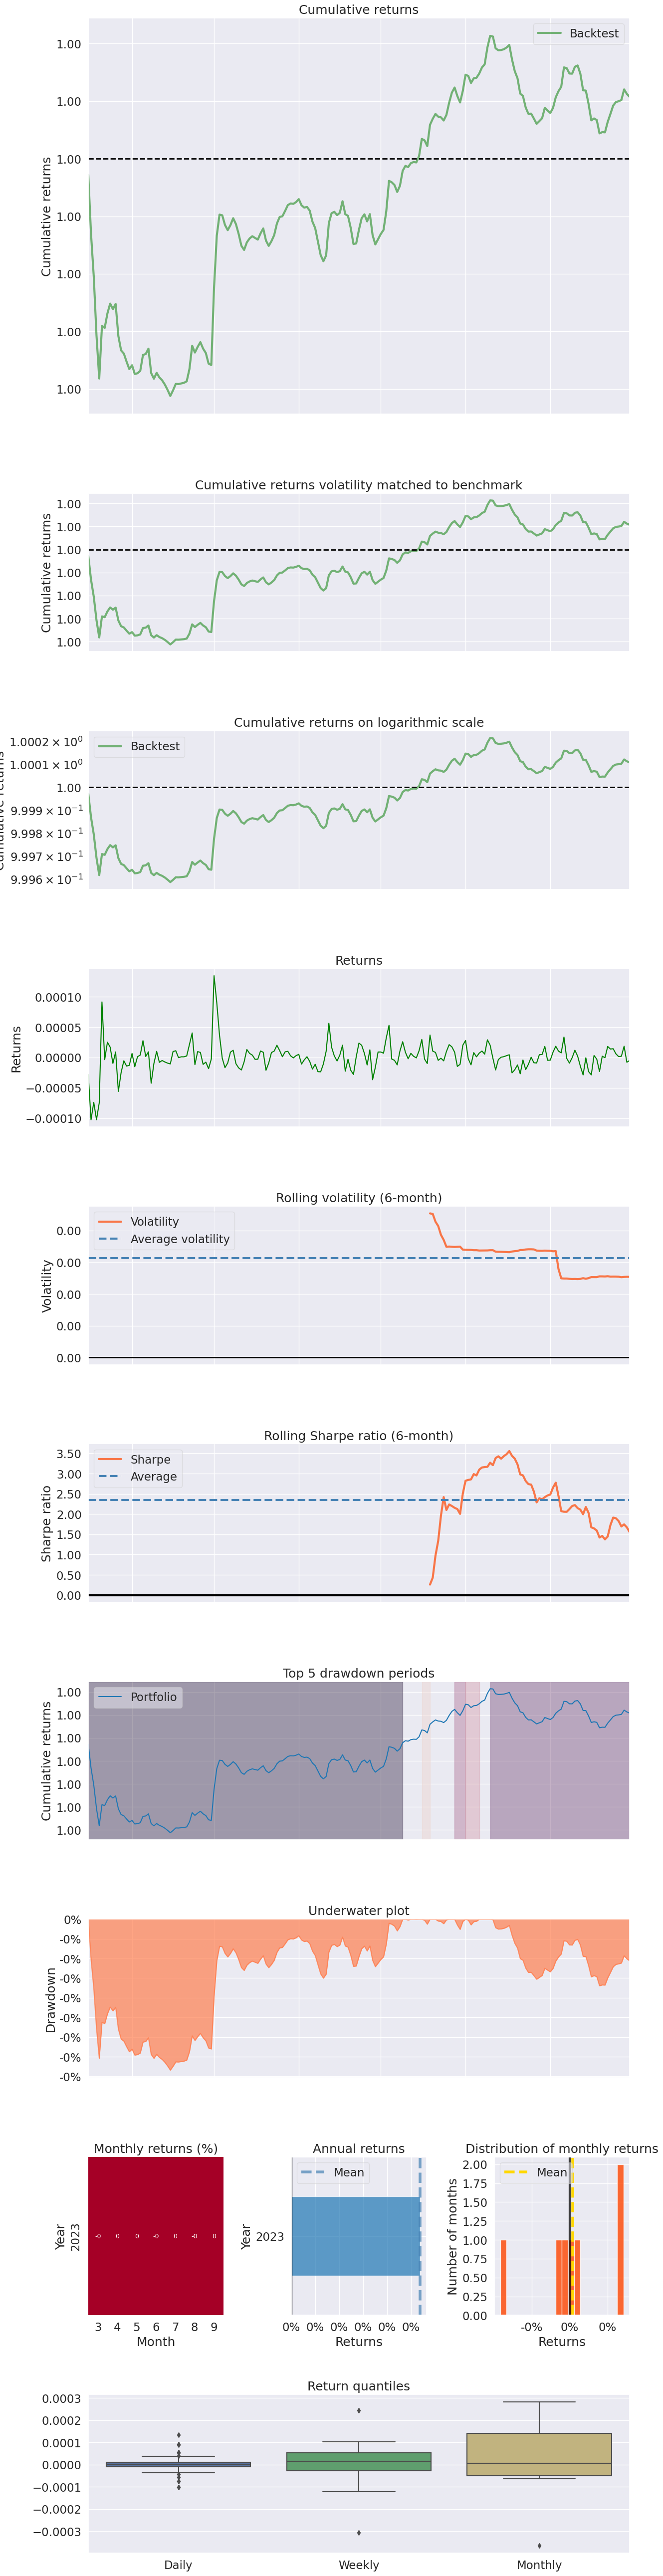

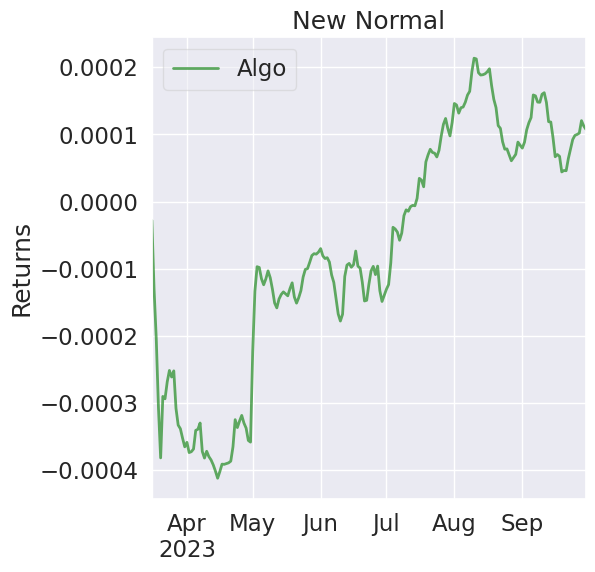

In [21]:
import pyfolio

pyfolio.tears.create_full_tear_sheet(best_return['returns'])